### Modelos
- Modelo Óbito-Curado (60/40): Regressão
- Modelo Internado-Curado (70/30): AdaBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
import modelofuncoes as mf

from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

importing Jupyter notebook from modelofuncoes.ipynb


### Curva ROC

In [2]:
def exibirCurvaROC(modeloClassificador, x_test, y_test):
    y_preds = modeloClassificador.predict_proba(x_test)

    # take the second column because the classifier outputs scores for the 0 class as well
    preds = y_preds[:,1]

    # fpr (false-positive-rate) e tpr (true-positive-rate)
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    auc_score = metrics.auc(fpr, tpr)

    # Construindo o Gráfico
    plt.clf()
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
    plt.plot([0,1],[0,1],'r--')

    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.legend(loc='lower right')
    plt.show()

### Avaliando o Smote

In [3]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

def aplicarSmote(base, alvo):

    X_smt = base.drop(alvo, axis = 1)
    y_smt = base[alvo]
    
    # Contar o número de ocorrências
    # np.bincount(y_smt)
    
    # Carregar o Smote
    smt = SMOTE()
    
    # Aplicar o Smote
    X_smt, y_smt = smt.fit_resample(X_smt, y_smt)
    
    # Contar o número de ocorrências
    # np.bincount(y_smt)
    
    # Convertendo em DF
    smoteBase = pd.DataFrame(X_smt)
    smoteBase[alvo] = y_smt
    
    return smoteBase

In [4]:
hiperparametrosGB = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, 
                           random_state=1859, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## Desempenho dos Modelos Escolhidos
---------

### Definindo as bases de dados

In [24]:
# Modelo OC (7030 e Smote 7030)
# url = 'PreProcessamento/balanceadas/OC/ba-oc-7030-sp.xlsx'
#url = 'PreProcessamento/balanceadas/Smote/sm-oc-7030-sp.xlsx'

# Modelo IC (Smote 6040)
# url = 'PreProcessamento/balanceadas/Smote/sm-ic-6040-sp.xlsx'
url = 'PreProcessamento/balanceadas/IC/ba-ic-6040-sp.xlsx'

alvo = 'evolucaoCaso'
baseFinal = pd.read_excel(url)

In [25]:
print(baseFinal.shape)
print(baseFinal[alvo].value_counts())

(1817, 38)
1    1090
0     727
Name: evolucaoCaso, dtype: int64


### Reduzindo os Atributos

In [26]:
# (Modelo OC)
# atributosSelecionados = ['faixaetaria', 'dispneia', 'qntVacinas', 'coriza', 'dorDeGarganta', 
#                        'dorDeCabeca', 'obesidade', 'diabetes', 'faixaDiasSintomas', 'evolucaoCaso']

# (Modelo IC)
atributosSelecionados = ['faixaetaria', 'dorDeCabeca', 'dorDeGarganta', 'renal', 'dispneia', 'diabetes',  
                       'tosse', 'qntVacinas', 'faixaDiasSintomas', 'coriza', 'febre', 'evolucaoCaso']

In [27]:
baseFinalReduzida = baseFinal.loc[:, atributosSelecionados]

In [28]:
#baseFinalReduzida['evolucaoCaso'] = baseFinalReduzida['evolucaoCaso'].map({0:2, 1:1})
baseFinalReduzida['evolucaoCaso'].value_counts()

1    1090
0     727
Name: evolucaoCaso, dtype: int64

In [29]:
baseFinalReduzida.shape

(1817, 12)

### Carregando o Modelo Escolhido

In [30]:
x_train, x_test, y_train, y_test = train_test_split(baseFinalReduzida.drop(alvo,axis=1),
                                                    baseFinalReduzida[alvo],
                                                    test_size=0.3,
                                                    random_state=42);

In [31]:
# Fit nos dados
modeloClassificador = hiperparametrosGB
modeloClassificador.fit(x_train, y_train)

#Realizando a predição
resultadoTeste = modeloClassificador.predict(x_test)

# Verificando a acurácia
print(metrics.classification_report(y_test, resultadoTeste))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60       217
           1       0.73      0.82      0.77       329

    accuracy                           0.71       546
   macro avg       0.70      0.68      0.69       546
weighted avg       0.71      0.71      0.71       546



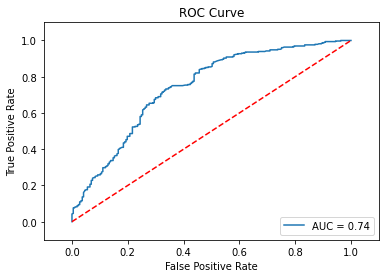

In [33]:
exibirCurvaROC(modeloClassificador, x_test, y_test)

------

### Selecionando as bases para a Validação

In [15]:
# Bases - OC
# top10_bases_modelo_oc_map = {'MG': 'PreProcessamento/balanceadas/OC/ba-oc-7030-mg.xlsx',
#                          'BA': 'PreProcessamento/balanceadas/OC/ba-oc-7030-ba.xlsx',
#                          'PA': 'PreProcessamento/balanceadas/OC/ba-oc-7030-pa.xlsx',
#                          'RO': 'PreProcessamento/balanceadas/OC/ba-oc-7030-ro.xlsx',
#                          'RJ': 'PreProcessamento/balanceadas/OC/ba-oc-7030-rj.xlsx',
#                          'SC': 'PreProcessamento/balanceadas/OC/ba-oc-7030-sc.xlsx',
#                          'CE': 'PreProcessamento/balanceadas/OC/ba-oc-7030-ce.xlsx',
#                          'RS': 'PreProcessamento/balanceadas/OC/ba-oc-7030-rs.xlsx',
#                          'TO': 'PreProcessamento/balanceadas/OC/ba-oc-7030-to.xlsx',
#                          'MT': 'PreProcessamento/balanceadas/OC/ba-oc-7030-mt.xlsx',
#                         }

# top10_bases_modelo_oc = ['ba-oc-7030-mg.xlsx', 'ba-oc-7030-ba.xlsx', 'ba-oc-7030-pa.xlsx', 
#                          'ba-oc-7030-ro.xlsx', 'ba-oc-7030-rj.xlsx', 'ba-oc-7030-sc.xlsx', 
#                          'ba-oc-7030-ce.xlsx', 'ba-oc-7030-rs.xlsx', 'ba-oc-7030-to.xlsx', 
#                          'ba-oc-7030-mt.xlsx']

In [34]:
# Bases - IC
# top10_bases_modelo_ic_map = {'BA': 'PreProcessamento/balanceadas/IC/ba-ic-6040-sp.xlsx',
#                         'MG': 'PreProcessamento/balanceadas/IC/ba-ic-6040-mg.xlsx',
#                         'SC': 'PreProcessamento/balanceadas/IC/ba-ic-6040-sc.xlsx',
#                         'RS': 'PreProcessamento/balanceadas/IC/ba-ic-6040-rs.xlsx',
#                         'RJ': 'PreProcessamento/balanceadas/IC/ba-ic-6040-rj.xlsx',
#                         'PB': 'PreProcessamento/balanceadas/IC/ba-ic-6040-pb.xlsx',
#                         'GO': 'PreProcessamento/balanceadas/IC/ba-ic-6040-go.xlsx',
#                         'CE': 'PreProcessamento/balanceadas/IC/ba-ic-6040-ce.xlsx',
#                         'DF': 'PreProcessamento/balanceadas/IC/ba-ic-6040-df.xlsx',
#                         'PA': 'PreProcessamento/balanceadas/IC/ba-ic-6040-pa.xlsx'
#                         }

top10_bases_modelo_ic = ['ba-ic-6040-sp.xlsx', 'ba-ic-6040-mg.xlsx', 'ba-ic-6040-sc.xlsx',
                        'ba-ic-6040-rs.xlsx', 'ba-ic-6040-rj.xlsx', 'ba-ic-6040-pb.xlsx',
                        'ba-ic-6040-go.xlsx', 'ba-ic-6040-ce.xlsx', 'ba-ic-6040-df.xlsx',
                        'ba-ic-6040-pa.xlsx']

In [36]:
# (Modelo OC)
# colunasSelecionadasTeste = ['faixaetaria', 'dispneia', 'qntVacinas', 'coriza', 'dorDeGarganta', 
#                        'dorDeCabeca', 'obesidade', 'diabetes', 'faixaDiasSintomas']

# (Modelo IC)
colunasSelecionadasTeste = ['faixaetaria', 'dorDeCabeca', 'dorDeGarganta', 'renal', 'dispneia', 'diabetes',  
                       'tosse', 'qntVacinas', 'faixaDiasSintomas', 'coriza', 'febre']

### Executando a Validação

In [37]:
alvos = [0, 1]
default_path = 'PreProcessamento/balanceadas/IC/'
listaBases = top10_bases_modelo_ic
alvo = 'evolucaoCaso'

desempenhoDosModelos = pd.DataFrame()
for indice in range(0, len(listaBases)):
    covidData = pd.read_excel(default_path + listaBases[indice])
    dadosTeste = covidData.loc[:, colunasSelecionadasTeste]
    dadosAlvo =  covidData.loc[:, alvo]
     
    metricasMap = mf.calcularMetricasValidacao(dadosTeste, dadosAlvo, listaBases[indice], modeloClassificador, alvos)
    desempenhoDosModelos = pd.concat([desempenhoDosModelos, pd.DataFrame([metricasMap])]) 

In [38]:
desempenhoDosModelos

,Acurácia,AUC,Base,Precisão (0),Recall (0),F1-Score (0),Precisão (1),Recall (1),F1-Score (1)
0,77.00,0.83,ba-ic-6040-sp.xlsx,75.71,62.59,68.52,77.63,86.61,81.87
0,77.49,0.80,ba-ic-6040-mg.xlsx,74.72,66.17,70.18,79.01,85.05,81.92
0,74.90,0.77,ba-ic-6040-sc.xlsx,75.17,55.72,64.00,74.79,87.71,80.73
0,70.34,0.72,ba-ic-6040-rs.xlsx,68.70,47.62,56.25,70.97,85.51,77.56
0,72.48,0.77,ba-ic-6040-rj.xlsx,67.11,61.35,64.10,75.58,79.92,77.69
0,66.21,0.66,ba-ic-6040-pb.xlsx,65.75,32.65,43.64,66.33,88.64,75.88
0,68.02,0.65,ba-ic-6040-go.xlsx,66.13,41.41,50.93,68.65,85.81,76.28
0,74.87,0.78,ba-ic-6040-ce.xlsx,78.43,51.95,62.50,73.57,90.35,81.10
0,71.03,0.78,ba-ic-6040-df.xlsx,62.50,69.77,65.93,77.97,71.88,74.80
0,70.06,0.76,ba-ic-6040-pa.xlsx,62.32,64.18,63.24,75.51,74.00,74.75


### Calculando a média das Métricas

In [39]:
# Identificando a média 
media = desempenhoDosModelos.mean()

# Inserindo as outras colunas
# media['Modelo'] = "-"
media['Base'] = 'Média dos Modelos'

/tmp/ipykernel_8557/1463340102.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  media = desempenhoDosModelos.mean()


In [40]:
# Adicionando a média dos valores
desempenhoDosModelos = desempenhoDosModelos.append(media, ignore_index=True)
desempenhoDosModelos

,Acurácia,AUC,Base,Precisão (0),Recall (0),F1-Score (0),Precisão (1),Recall (1),F1-Score (1)
0,77.00,0.830,ba-ic-6040-sp.xlsx,75.710,62.590,68.520,77.630,86.610,81.870
1,77.49,0.800,ba-ic-6040-mg.xlsx,74.720,66.170,70.180,79.010,85.050,81.920
2,74.90,0.770,ba-ic-6040-sc.xlsx,75.170,55.720,64.000,74.790,87.710,80.730
3,70.34,0.720,ba-ic-6040-rs.xlsx,68.700,47.620,56.250,70.970,85.510,77.560
4,72.48,0.770,ba-ic-6040-rj.xlsx,67.110,61.350,64.100,75.580,79.920,77.690
5,66.21,0.660,ba-ic-6040-pb.xlsx,65.750,32.650,43.640,66.330,88.640,75.880
6,68.02,0.650,ba-ic-6040-go.xlsx,66.130,41.410,50.930,68.650,85.810,76.280
7,74.87,0.780,ba-ic-6040-ce.xlsx,78.430,51.950,62.500,73.570,90.350,81.100
8,71.03,0.780,ba-ic-6040-df.xlsx,62.500,69.770,65.930,77.970,71.880,74.800
9,70.06,0.760,ba-ic-6040-pa.xlsx,62.320,64.180,63.240,75.510,74.000,74.750


In [42]:
# Convertendo series para dict
# media_dict = pd.Series(media.values, index=media.keys).to_dict()

### Salvando o Desempenho

In [43]:
mf.salvarBaseDeDados(desempenhoDosModelos, 'validacao-modelo-ic.xlsx')